# Swiss food consumption and provenance (ML2)

In this notebook you will find the preliminary analysis of the UN FAOSTAT dataset in which we study in depth the possibilities offered by the data. 

The purpose of this analysis is to provide with the needed intuition about what can be answered with the dataset and what's not. While in the same time discover the data types, units, codes, hidden content or possible missing data. This is a mandatory step that we need to do before starting digging in the problem and set the first building blocks for the data story design.


## General Imports

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data preparation

<!-- toc -->
### 1.1 Swiss production
#### 1.1.1 Data Description
The FAO Database offers a variety of datasets containing information about the production of every country for all years between 1961 and 2017.
##### Crops
<details>
  <summary>Description</summary> 
  Crop statistics are recorded for 173 products, covering the following categories: Crops Primary, Fibre Crops Primary, Cereals, Coarse Grain, Citrus Fruit, Fruit, Jute Jute-like Fibres, Oilcakes Equivalent, Oil crops Primary, Pulses, Roots and Tubers, Treenuts and Vegetables and Melons. Data are expressed in terms of area harvested, production quantity and yield. The objective is to comprehensively cover production of all primary crops for all countries and regions in the world.
</details>

<details>
  <summary>Path</summary>
  
  Data/FAOSTAT/Production_Crops_E_All_Data_(Normalized).zip
</details>

##### Crops Processed
<details>
  <summary>Description</summary>  
  The dataset covers the following commodities: Beer of barley; Cotton lint; Cottonseed; Margarine, short; Molasses; Oil, coconut (copra); Oil, cottonseed; Oil, groundnut; Oil, linseed; Oil, maize; Oil, olive, virgin; Oil, palm; Oil, palm kernel; Oil, rapeseed; Oil, safflower; Oil, sesame; Oil, soybean; Oil, sunflower; Palm kernels; Sugar Raw Centrifugal; Wine.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Production_CropsProcessed_E_All_Data_(Normalized).zip
</details>

##### Live Animals
<details>
  <summary>Description</summary>  
  The dataset contains the following commodities and commodity aggregates thereof : Animals live n.e.s.; Asses; Beehives; Buffaloes; Camelids, other; Camels; Cattle; Chickens; Ducks; Geese and guinea fowls; Goats; Horses; Mules; Pigeons, other birds; Pigs; Rabbits and hares; Rodents, other; Sheep; Turkeys.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Production_Livestock_E_All_Data_(Normalized).zip
</details>

##### Livestock Primary
<details>
  <summary>Description</summary>  
  The dataset contains the following commodities and commodity aggregates thereof : Beeswax; Eggs (various types); Hair, horse; Hides buffalo, fresh; Hides, cattle, fresh; Honey, natural; Meat indigenous (ass, bird nes, buffalo, camel, cattle, chicken, duck, geese, goat, horse, mule, other camelids, pig, rabbit, rodents, sheep, turkey); Meat (ass, bird nes, buffalo, camel, cattle, chicken, duck, game, goat, goose and guinea fowl, horse, mule, Meat nes, meat other camelids, Meat other rodents, pig, rabbit, sheep, turkey); Milk (buffalo, camel, cow, goat, sheep); Offals, nes; Silk-worm cocoons, reelable; Skins, furs; Skins (goat, sheep); Snails, not sea; Wool, greasy. 
    The data presented in the table are incomplete, particularly with regard to African and Asian countries.
    
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Production_LivestockPrimary_E_All_Data_(Normalized).zip
</details>

##### Livestock Processed
<details>
  <summary>Description</summary>  
  The dataset covers the following commodities: Butter and ghee, sheep milk; Butter of goat milk; Butter, buffalo milk; Butter, cow milk; Cheese of goat milk; Cheese, buffalo milk; Cheese, sheep milk; Cheese, skimmed cow milk; Cheese, whole cow milk; Cream fresh; Ghee, butteroil of cow milk; Ghee, of buffalo milk; Lard; Milk, dry buttermilk; Milk, skimmed condensed; Milk, skimmed cow; Milk, skimmed dried; Milk, skimmed evaporated; Milk, whole condensed; Milk, whole dried; Milk, whole evaporated; Silk raw; Tallow; Whey, condensed; Whey, dry; Yoghurt
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Production_LivestockProcessed_E_All_Data_(Normalized).zip
</details>

##### Production Indices
<details>
  <summary>Description</summary>  
  The dataset includes data on gross and net production indices for various food and agriculture aggregates expressed in both totals and per capita.
    The FAO indices of agricultural production show the relative level of the aggregate volume of agricultural production for each year in comparison with the base period 2004-2006. They are based on the sum of price-weighted quantities of different agricultural commodities produced after deductions of quantities used as seed and feed weighted in a similar manner.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Production_Indices_E_All_Data_(Normalized).zip
</details>

##### Value of Agricultural Production
<details>
  <summary>Description</summary>  
  The data set includes data on gross and net production values, in constant international US\$, and gross production values, in constant and current US\$ and Local Currency Units, for various food and agriculture commodities and aggregates thereof, expressed in both total value and value per capita
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Value_of_Production_E_All_Data_(Normalized).zip
</details>

We are mainly interested in the production of all different type of food in Switzerland. For this reason we will not use "Live Animals", but rather combine the Crops and Livestock produced in Switzerland.

We will not use "Production Indices" and "Value of Agricultural Production" for now because they only contain monetary value and do not contain all data; in particular they only take into consideration Primary Crops and Livestock. We can use them as is if we want a simpler dataset.

#### 1.1.2 Data Cleaning

In [20]:
"""Load the Data"""
crops_df = pd.read_csv('Data/FAOSTAT/Production_Crops_E_All_Data_(Normalized).zip', sep=',', encoding = "ISO-8859-1")
crops_processed_df = pd.read_csv('Data/FAOSTAT/Production_CropsProcessed_E_All_Data_(Normalized).zip', sep=',', encoding = "ISO-8859-1")
livestock_primary_df = pd.read_csv('Data/FAOSTAT/Production_LivestockPrimary_E_All_Data_(Normalized).zip', sep=',', encoding = "ISO-8859-1")
livestock_processed_df = pd.read_csv('Data/FAOSTAT/Production_LivestockProcessed_E_All_Data_(Normalized).zip', sep=',', encoding = "ISO-8859-1")

In [7]:
"""Extract Switzerland Production"""
CH_code = 211 # Switzerland Area Code is 211
crops_df_CH = crops_df[crops_df['Area Code'] == CH_code]
crops_processed_df_CH = crops_processed_df[crops_processed_df['Area Code'] == CH_code]
livestock_primary_df_CH = livestock_primary_df[livestock_primary_df['Area Code'] == CH_code]
livestock_processed_df_CH = livestock_processed_df[livestock_processed_df['Area Code'] == CH_code]

NameError: name 'crops_df' is not defined

In [4]:
"""Combines the dataframes into one"""
production_df_CH = pd.concat([crops_df_CH, crops_processed_df_CH, livestock_primary_df_CH, livestock_processed_df_CH])
production_df_CH.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1501762,211,Switzerland,515,Apples,5312,Area harvested,1961,1961,ha,2700.0,F
1501763,211,Switzerland,515,Apples,5312,Area harvested,1962,1962,ha,4800.0,F
1501764,211,Switzerland,515,Apples,5312,Area harvested,1963,1963,ha,3600.0,F
1501765,211,Switzerland,515,Apples,5312,Area harvested,1964,1964,ha,4000.0,F
1501766,211,Switzerland,515,Apples,5312,Area harvested,1965,1965,ha,2478.0,NaN


In many cases we are only interested in the production quantity rather than the amount of resources needed for the production.

In [5]:
"""Only keep production quantity"""
prod_quant_df_CH = production_df_CH[production_df_CH['Element'] == 'Production']
prod_quant_df_CH.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1501876,211,Switzerland,515,Apples,5510,Production,1961,1961,tonnes,269800.0,NaN
1501877,211,Switzerland,515,Apples,5510,Production,1962,1962,tonnes,480400.0,NaN
1501878,211,Switzerland,515,Apples,5510,Production,1963,1963,tonnes,359600.0,NaN
1501879,211,Switzerland,515,Apples,5510,Production,1964,1964,tonnes,389600.0,NaN
1501880,211,Switzerland,515,Apples,5510,Production,1965,1965,tonnes,255400.0,NaN


In [6]:
"""Check Units"""
prod_quant_df_CH['Unit'].value_counts()

tonnes       7414
Head          265
1000 Head     212
1000 No        57
Name: Unit, dtype: int64

We notice a few different units, the most frequent one being `tonnes`. We need to check what the other units correspond to to see if we should remove them.

In [7]:
"""Items expressed in Head or 1000 Head"""
prod_quant_df_CH[(prod_quant_df_CH['Unit'] == 'Head') | (prod_quant_df_CH['Unit'] == '1000 Head')]['Item'].value_counts()

Meat indigenous, sheep      53
Meat indigenous, poultry    53
Meat indigenous, cattle     53
Meat indigenous, rabbit     53
Meat indigenous, chicken    53
Meat indigenous, pig        53
Meat indigenous, goat       53
Meat indigenous, turkey     53
Meat indigenous, horse      53
Name: Item, dtype: int64

In [8]:
"""Same items expressed in tonnes"""
prod_quant_df_CH[prod_quant_df_CH['Item'].str.contains('Meat indigenous') & (prod_quant_df_CH['Unit'] == 'tonnes')]['Item'].value_counts()

Meat indigenous, total      53
Meat indigenous, sheep      53
Meat indigenous, poultry    53
Meat indigenous, cattle     53
Meat indigenous, rabbit     53
Meat indigenous, chicken    53
Meat indigenous, pig        53
Meat indigenous, goat       53
Meat indigenous, turkey     53
Meat indigenous, horse      53
Name: Item, dtype: int64

In [9]:
"""Items expressed in 1000 No"""
prod_quant_df_CH[prod_quant_df_CH['Unit'] == '1000 No']['Item'].value_counts()

Eggs, hen, in shell (number)    57
Name: Item, dtype: int64

In [10]:
"""Same items expressed in tonnes"""
prod_quant_df_CH[prod_quant_df_CH['Item'].str.contains('Eggs, hen, in shell') & (prod_quant_df_CH['Unit'] == 'tonnes')]['Item'].value_counts()

Eggs, hen, in shell    57
Name: Item, dtype: int64

We notices that the items expressed with those other units also have a values in tonnes. Thus, we can safely remove the rows with the other units as they do not provide extra information.

The following dataframe then provides the complete swiss food production in terms of tonnes from 1961 to 2017. A few items have missing data as the starting year of their report is not always similar. 

In [11]:
"""Complete Swiss food production fataframe"""
prod_quant_df_CH = prod_quant_df_CH[prod_quant_df_CH['Unit'] == 'tonnes']
prod_quant_df_CH.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1501876,211,Switzerland,515,Apples,5510,Production,1961,1961,tonnes,269800.0,NaN
1501877,211,Switzerland,515,Apples,5510,Production,1962,1962,tonnes,480400.0,NaN
1501878,211,Switzerland,515,Apples,5510,Production,1963,1963,tonnes,359600.0,NaN
1501879,211,Switzerland,515,Apples,5510,Production,1964,1964,tonnes,389600.0,NaN
1501880,211,Switzerland,515,Apples,5510,Production,1965,1965,tonnes,255400.0,NaN


#### 1.1.3 Pending Questions
* Missing Data: Do we keep it as is? Set to 0?
* Flags: Are they useful? How would we use them?
* Items: Duplicates?

---

### 1.2 Swiss imports/exports
#### 1.2.1 Data Description
The FAO Database offers a variety of datasets containing information about the imports/exports quantities and values of every country for all years between 1961 and 2017.
##### Crops and livestock products
<details>
  <summary>Description</summary> 
  The trade database includes the following variables: export quantity, export value, import quantity, and import value. The trade database includes all food and agricultural products imported/exported annually by all the countries in the world.
</details>

<details>
  <summary>Path</summary>
  
  Data/FAOSTAT/Trade_Crops_Livestock_E_All_Data_(Normalized).zip
</details>

##### Live animals
<details>
  <summary>Description</summary> 
  The trade database includes the following variables: export quantity, export value, import quantity, and import value. The trade database includes all live animals imported/exported annually by all the countries in the world.
</details>

<details>
  <summary>Path</summary>
  
  Data/FAOSTAT/Trade_LiveAnimals_E_All_Data_(Normalized).zip
</details>

##### Detailed trade matrix
<details>
  <summary>Description</summary> 
   The trade database includes the following variables: export quantity, export value, import quantity and import value. The trade database includes all food and agricultural products as well as live animals imported/exported annually by all the countries in the world. It also includes the provenance/destination of each import/export.
</details>

<details>
  <summary>Path</summary>
  
  Data/FAOSTAT/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip
</details>

##### Trade Indices
<details>
  <summary>Description</summary> 
  Import/Exports Indices for every country. This only includes the year 2017 and fits the items into two categories.
</details>

<details>
  <summary>Path</summary>
  
  Data/FAOSTAT/Trade_Indices_E_All_Data_(Normalized).zip
</details>

Since we are interested in the provenance of each imports, we will mainly use the Detailed Trade Matrix. The Crops and Livestock products could be useful to us if we do not need the provenance. The Trade Indices dataset does not provide any useful information.

#### 1.2.2 Data Cleaning

In [12]:
"""Load Data"""
tradematrix_df = pd.read_csv('Data/FAOSTAT/Trade_DetailedTradeMatrix_E_All_Data_(Normalized).zip', sep=',', encoding = "ISO-8859-1")

In [13]:
tradematrix_df.head()

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5910,Export Quantity,2016,2016,tonnes,3.0,*
1,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5922,Export Value,2016,2016,1000 US$,23.0,*
2,2,Afghanistan,4,Algeria,1293,Crude materials,5922,Export Value,2015,2015,1000 US$,1.0,*
3,2,Afghanistan,4,Algeria,1293,Crude materials,5922,Export Value,2016,2016,1000 US$,1.0,*
4,2,Afghanistan,4,Algeria,1293,Crude materials,5922,Export Value,2017,2017,1000 US$,5.0,R


In [14]:
"""Extract Switzerland Trades"""
CH_code = 211 # Switzerland Area Code is 211
tradematrix_df_CH = tradematrix_df[tradematrix_df['Reporter Country Code'] == CH_code]

In [15]:
"""Check Units"""
tradematrix_df_CH['Unit'].value_counts()

1000 US$     297067
tonnes       291194
Head           3106
1000 Head       366
No               13
Name: Unit, dtype: int64

Again, we notice a few different units, the most frequent one being `tonnes` for quantity and `1000 US$` for value. We need to check what the other units correspond to to see if we should remove them.

In [16]:
"""Items expressed in Head, 1000 Head or No"""
tradematrix_df_CH[(tradematrix_df_CH['Unit'] == 'Head') | (tradematrix_df_CH['Unit'] == '1000 Head') | (tradematrix_df_CH['Unit'] == 'No')]['Item'].value_counts()

Horses               1586
Cattle                474
Chickens              271
Sheep                 239
Goats                 203
Asses                 188
Pigs                  184
Animals live nes      139
Camelids, other        45
Ducks                  36
Mules                  33
Rabbits and hares      31
Turkeys                28
Buffaloes              15
Beehives               13
Name: Item, dtype: int64

We see these units correspond to all live animals. As mentioned before, since we are interested in consumable food we do not need these items and thus can remove them. However, if we remove them if must make sure to remove also the live animals expressed in 1000 US$.

In [17]:
"""Create list of item codes corresponding to live animals"""
liveanimals_codes = tradematrix_df_CH[(tradematrix_df_CH['Unit'] == 'Head') | (tradematrix_df_CH['Unit'] == '1000 Head') | (tradematrix_df_CH['Unit'] == 'No')]['Item Code'].unique()

"""Remove rows with those items"""
tradematrix_df_CH = tradematrix_df_CH[tradematrix_df_CH['Item Code'].apply(lambda code: code in liveanimals_codes) == False]

In [18]:
"""Check units again"""
tradematrix_df_CH['Unit'].value_counts()

1000 US$    293575
tonnes      290668
Name: Unit, dtype: int64

Now that we have a more homogeneous dataset, we want to separate the four different elements i.e. Export/Import in terms of Quantity/Value.

In [19]:
"""Check different elements"""
tradematrix_df_CH['Element'].value_counts()

Import Value       177026
Import Quantity    175231
Export Value       116549
Export Quantity    115437
Name: Element, dtype: int64

In [20]:
"""Separate in four dataframes"""
imports_quant_df_CH = tradematrix_df_CH[tradematrix_df_CH['Element'] == 'Import Quantity']
imports_val_df_CH = tradematrix_df_CH[tradematrix_df_CH['Element'] == 'Import Value']
exports_quant_df_CH = tradematrix_df_CH[tradematrix_df_CH['Element'] == 'Export Quantity']
exports_val_df_CH = tradematrix_df_CH[tradematrix_df_CH['Element'] == 'Export Value']

Those four dataframes provide the swiss import/exports in terms of quantity and value from 1961 to 2017. It has no NaN values, only a lot of 0 values. 

#### 1.2.3 Pending Questions
* Flags: Are they useful? How would we use them?
* Items: Duplicates?
* Join the four dataframes to have the four values in each row? Then ignore flags?

---

### 1.3 Item Classification

#### 1.3.1 Data Description
The FAO database use different items forms for different datasets. To be able to make the connection between the datasets we must create a link between the different items forms.
By analyzing the different datasets we observed that each item is classified with the following hierarchy.
##### Classification Hierarchy
<details>
  <summary>Type</summary> 
  Vegetal or Animal
</details>

<details>
  <summary>Group</summary> 
  One of the following:
    
    'Treenuts', 'Spices', 'Fruits - Excluding Wine', 'Vegetables',
       'Meat', 'Pulses', 'Cereals - Excluding Beer',
       'Alcoholic Beverages', 'Sugar & Sweeteners', 'Vegetable Oils',
       'Animal fats', 'Starchy Roots', 'Stimulants', 'Oilcrops',
       'Miscellaneous', 'Offals', 'Sugar Crops'
</details>

<details>
  <summary>Subgroup</summary> 
  One of the following:
    
    'Nuts and products', 'Spices, Other', 'Apples and products',
       'Fruits, Other', 'Vegetables, Other', 'Pigmeat',
       'Pulses, Other and products', 'Bananas', 'Barley and products',
       'Beans', 'Beer', 'Beverages, Fermented', 'Beverages, Alcoholic',
       'Sweeteners, Other', 'Cereals, Other', 'Maize and products',
       'Millet and products', 'Sorghum and products',
       'Wheat and products', 'Oilcrops Oil, Other', 'Butter, Ghee',
       'Cassava and products', 'Pimento', 'Cocoa Beans and products',
       'Cloves', 'Coconuts - Incl Copra', 'Coffee and products',
       'Cottonseed', 'Cream', 'Dates', 'Fats, Animals, Raw',
       'Poultry Meat', 'Palm Oil', 'Rape and Mustardseed',
       'Potatoes and products', 'Rice (Milled Equivalent)',
       'Roots, Other', 'Grapefruit and products',
       'Grapes and products (excl wine)', 'Groundnuts (Shelled Eq)',
       'Honey', 'Infant food', 'Citrus, Other',
       'Lemons, Limes and products', 'Oranges, Mandarines',
       'Pineapples and products', 'Tomatoes and products',
       'Oilcrops, Other', 'Tea (including mate)', 'Meat, Other',
       'Bovine Meat', 'Mutton & Goat Meat', 'Oats', 'Offals, Edible',
       'Coconut Oil', 'Cottonseed Oil', 'Groundnut Oil', 'Maize Germ Oil',
       'Olive Oil', 'Palmkernel Oil', 'Rape and Mustard Oil',
       'Ricebran Oil', 'Sesameseed Oil', 'Soyabean Oil',
       'Sunflowerseed Oil', 'Olives (including preserved)', 'Onions',
       'Peas', 'Pepper', 'Plantains', 'Rye and products', 'Sesame seed',
       'Soyabeans', 'Sugar beet', 'Sugar (Raw Equivalent)',
       'Sugar non-centrifugal', 'Sunflower seed', 'Sweet potatoes',
       'Wine'
</details>


Unfortunately, the FAO database does not provide an immediate dataset corresponding to this hierarchy. However it does provide some files allowing us the make the connection between each hierarchy levels.

##### Items Codes
<details>
  <summary>Description</summary> 
  This dataset contains every product names as well as their FAO code.
</details>

<details>
  <summary>Path</summary> 
  Data/items_codes.csv
</details>

##### Items Subgroups
<details>
  <summary>Description</summary> 
  This dataset contains every groups and subgroups names as well as their FAO code. The description of each subgroups includes all the items contained in the subgroup
</details>

<details>
  <summary>Path</summary> 
  Data/items_subgroups.csv
</details>

##### Items Groups
<details>
  <summary>Description</summary> 
  This dataset contains every group and subgroups as well as their FAO code. It has the relation between groups and subgroups
</details>

<details>
  <summary>Path</summary> 
  Data/items_groups.csv
</details>


To obtain the hierarchy in one dataset we need to clean up and combine those three datasets.
#### 1.3.2 Data Cleaning

In [17]:
"""Load Data"""
items_codes =pd.read_csv('Data/items_codes.csv', sep=',', encoding = "ISO-8859-1")
items_subgroups =pd.read_csv('Data/items_subgroups.csv', sep=',', encoding = "ISO-8859-1")
items_groups =pd.read_csv('Data/items_groups.csv', sep=',', encoding = "ISO-8859-1")

In [18]:
"""Filter and rename columns to obtain only what we need for classification"""
items_codes = items_codes[['Item Code', 'Item', 'Description']]

items_subgroups = items_subgroups[['Item Code', 'Item', 'Description']]
items_subgroups = items_subgroups.rename(columns={'Item Code': 'Item Subgroup Code', 'Item': 'Item Subgroup', 'Description': 'Item Code'})

items_groups = items_groups[['Item Group Code', 'Item Group', 'Item Code']]
items_groups = items_groups.rename(columns={'Item Code': 'Item Subgroup Code'})

In [19]:
items_subgroups.head()

,Item Subgroup Code,Item Subgroup,Item Code
0,2659,"Alcohol, Non-Food",Default composition: 632 Alcohol non food
1,2924,Alcoholic Beverages,NaN
2,2946,Animal fats,NaN
3,2941,Animal Products,NaN
4,2617,Apples and products,"Default composition: 515 Apples, 518 Juice, ap..."


In `items_subgroups` we notice that the item codes are contained in the description. We need to use a regular expression to extract the codes from the textual descriptions.

In [20]:
"""Obtain item codes for each subgroup"""
items_subgroups['Item Code'] = items_subgroups['Item Code'].apply(lambda desc : re.findall(r"\d+", str(desc)))

We also see that some subgroups do not seem to have a description. However, a quick observation shows that these are actually groups and not subgroups. We choose to delete them to focus on subgroups for this dataset.

In [21]:
"""Remove subgroups that correspond to groups"""
items_subgroups = items_subgroups[items_subgroups['Item Subgroup'].apply(lambda item_subgroup: item_subgroup in items_groups['Item Group'].unique()) == False]

In [22]:
"""Check subgroups with no items"""
items_subgroups[items_subgroups['Item Code'].apply(lambda codes: len(codes) == 0)]

,Item Subgroup Code,Item Subgroup,Item Code
83,2501,Population,[]


We can see that removing the groups left us with only one element with no items. This element is the population and does not correspond to either a group or a subgroup so we can remove it.

In [23]:
"""Remove items with no category"""
items_subgroups = items_subgroups[items_subgroups['Item Code'].apply(lambda codes: len(codes) > 0)]

In [24]:
"""Explode item codes into separate rows"""
items_subgroups = items_subgroups.explode('Item Code')
items_subgroups['Item Code'] = items_subgroups['Item Code'].apply(lambda code: int(code))

We can now form the complete classification dataframe by joining our three dataframes.

In [59]:
"""Join the obtained dataframe to get full classification"""
items = items_codes.merge(items_subgroups, on='Item Code', how='inner')
items = items.merge(items_groups, on='Item Subgroup Code', how='inner')

In [60]:
"""Check values of groups"""
items['Item Group'].value_counts()

Grand Total                 307
Vegetal Products            265
Fruits - Excluding Wine      57
Cereals - Excluding Beer     43
Animal Products              42
Vegetables                   39
Vegetable Oils               27
Oilcrops                     24
Meat                         23
Treenuts                     15
Sugar & Sweeteners           14
Animal fats                  11
Stimulants                   10
Starchy Roots                10
Spices                        9
Pulses                        8
Offals                        8
Alcoholic Beverages           7
Miscellaneous                 1
Sugar Crops                   1
Name: Item Group, dtype: int64

We observe that some groups are not of the same hierarchy. In particular, `Grand Total` contains every item, `Vegetal Products` contain all vegetal products and `Animal Products` contain all animal products. We need to separate them from the other groups as they are a level higher in the hierarchy.

In [61]:
"""Remove Grand Total Category"""
items_no_total = items[items['Item Group'] != 'Grand Total']

"""Get index of animal and vegetal products"""
animal_vegetal_products = items[(items['Item Group'] == 'Animal Products') | (items['Item Group'] == 'Vegetal Products')]
"""Remove vegetal and animal products category to transform them into columns"""
items_only = items_no_total[(items_no_total['Item Group'] != 'Vegetal Products') & (items_no_total['Item Group'] != 'Animal Products')]

"""Add column 'Type' to determine if a product is vegetal or animal"""
items_only['Type'] = 'Vegetal'
items_only['Type'][np.array(animal_vegetal_products['Item Group'] == 'Animal Products')] = 'Animal'

We finally obtain the full classification dataframe.

In [62]:
items.head()

,Item Code,Item,Description,Item Subgroup Code,Item Subgroup,Item Group Code,Item Group
0,231,Almonds shelled,Around 55% of the weight in shell.,2551,Nuts and products,2901,Grand Total
1,231,Almonds shelled,Around 55% of the weight in shell.,2551,Nuts and products,2912,Treenuts
2,231,Almonds shelled,Around 55% of the weight in shell.,2551,Nuts and products,2903,Vegetal Products
3,221,"Almonds, with shell",Prunus amygdalus; P. communis; Amygdalus commu...,2551,Nuts and products,2901,Grand Total
4,221,"Almonds, with shell",Prunus amygdalus; P. communis; Amygdalus commu...,2551,Nuts and products,2912,Treenuts


In [63]:
items

,Item Code,Item,Description,Item Subgroup Code,Item Subgroup,Item Group Code,Item Group
0,231,Almonds shelled,Around 55% of the weight in shell.,2551,Nuts and products,2901,Grand Total
1,231,Almonds shelled,Around 55% of the weight in shell.,2551,Nuts and products,2912,Treenuts
2,231,Almonds shelled,Around 55% of the weight in shell.,2551,Nuts and products,2903,Vegetal Products
3,221,"Almonds, with shell",Prunus amygdalus; P. communis; Amygdalus commu...,2551,Nuts and products,2901,Grand Total
4,221,"Almonds, with shell",Prunus amygdalus; P. communis; Amygdalus commu...,2551,Nuts and products,2912,Treenuts
...,...,...,...,...,...,...,...
916,565,Vermouths & similar,Beverages made with wine of fresh grapes and f...,2655,Wine,2901,Grand Total
917,565,Vermouths & similar,Beverages made with wine of fresh grapes and f...,2655,Wine,2903,Vegetal Products
918,564,Wine,"Wines of fresh grapes of all qualities, includ...",2655,Wine,2924,Alcoholic Beverages
919,564,Wine,"Wines of fresh grapes of all qualities, includ...",2655,Wine,2901,Grand Total


---

### 1.4 Swiss Food Balance
#### 1.4.1 Data Description

##### Food Balance Sheets
<details>
  <summary>Description</summary> 
  This dataset contains all the informations about the food supply, the import/export quantity, the losses and also the feed/seed of each food for each country and for each year.
</details>

<details>
  <summary>Path</summary>
  
  Data/FAOSTAT/FoodBalanceSheets_E_All_Data_(Normalized).zip
</details>

#### 1.4.2 Data Cleaning

In [8]:
CH_code = 211 # Switzerland Area Code is 211

In [9]:
"""Load Data"""
food_balance_df = pd.read_csv('Data/FAOSTAT/FoodBalanceSheets_E_All_Data_(Normalized).zip', encoding="ISO-8859-1")

In [10]:
"""Filter Data to obtain only what we need"""
food_balance_df_CH = food_balance_df[food_balance_df['Area Code'] == CH_code]

In [11]:
"""Spread the elements in 'Elements' to columns to be able to work on data"""
values_wide = food_balance_df_CH.pivot_table(index=['Area', 'Item', 'Year'], columns='Element', values='Value')
food_balance_df_CH_wide = food_balance_df_CH[['Area', 'Item', 'Year']]\
                    .merge(values_wide, right_index=True, left_on=['Area', 'Item', 'Year'])\
                    .drop_duplicates()
        
food_balance_df_CH_wide.head()

,Area,Item,Year,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Feed,Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Losses,Other uses,Processing,Production,Protein supply quantity (g/capita/day),Seed,Stock Variation,Total Population - Both sexes
7741481,Switzerland,Population,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5393.0
7741482,Switzerland,Population,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5503.0
7741483,Switzerland,Population,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5618.0
7741484,Switzerland,Population,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5729.0
7741485,Switzerland,Population,1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5830.0


In [12]:
"""Inspect the food supply and others per year"""
food_balance_df_CH_wide.groupby('Year').sum().head()

,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Feed,Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Losses,Other uses,Processing,Production,Protein supply quantity (g/capita/day),Seed,Stock Variation,Total Population - Both sexes
Year,,,,,,,,,,,,,,,,
1961,15754.0,756.0,505.34,3799.0,9378.0,13815.0,1739.37,5185.0,451.0,208.0,1627.0,11140.0,351.95,291.0,185.0,5393.0
1962,16584.0,661.0,524.16,4290.0,9756.0,13459.0,1772.89,5565.0,429.0,240.0,1590.0,11569.0,332.71,285.0,117.0,5503.0
1963,16670.0,746.0,518.34,4433.0,9668.0,13161.0,1720.57,5438.0,415.0,267.0,1592.0,11485.0,338.38,297.0,495.0,5618.0
1964,17086.0,712.0,531.93,4316.0,9900.0,13326.0,1727.53,5943.0,398.0,265.0,1941.0,11907.0,336.65,275.0,-52.0,5729.0
1965,16876.0,723.0,521.01,4114.0,10166.0,13319.0,1743.16,6558.0,351.0,276.0,1717.0,10534.0,340.35,261.0,510.0,5830.0


#### Food Balance Comments 1

We clearly see that some numbers were totally unexpected while inspecting `food_balance`. For example, having +13'000 kcal/capita/day seem too much since we know we are eating around 2000-3000 kcal/capita/day.
We did some researches and found that some elements in `Item` are the group of other elements, and hence we have some duplicates values.

To resolve this problem, we need to separate the group items from the items. As we already investigate on the items and their groups, we can use our results to split `food_balance` into 2 dataframes, one which contain the elements and another one which contain only the groups.

We can also note that for all the columns that don't have any unit precision, the unit is '1000 tonnes'.

In [28]:
items_groups_array = items_groups['Item Group'].unique()
items_groups_array

array(['Alcoholic Beverages', 'Animal fats', 'Animal Products',
       'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs',
       'Fish, Seafood', 'Fruits - Excluding Wine', 'Grand Total', 'Meat',
       'Milk - Excluding Butter', 'Miscellaneous', 'Offals', 'Oilcrops',
       'Pulses', 'Spices', 'Starchy Roots', 'Stimulants',
       'Sugar & Sweeteners', 'Sugar Crops', 'Treenuts', 'Vegetable Oils',
       'Vegetables', 'Vegetal Products'], dtype=object)

In [29]:
items_subgroups_array = items_subgroups['Item Subgroup'].unique()
items_subgroups_array

array(['Alcohol, Non-Food', 'Apples and products',
       'Aquatic Animals, Others', 'Aquatic Plants', 'Bananas',
       'Barley and products', 'Beans', 'Beer', 'Beverages, Alcoholic',
       'Beverages, Fermented', 'Bovine Meat', 'Butter, Ghee',
       'Cassava and products', 'Cephalopods', 'Cereals, Other',
       'Citrus, Other', 'Cloves', 'Cocoa Beans and products',
       'Coconut Oil', 'Coconuts - Incl Copra', 'Coffee and products',
       'Cottonseed', 'Cottonseed Oil', 'Cream', 'Crustaceans', 'Dates',
       'Demersal Fish', 'Fats, Animals, Raw', 'Fish, Body Oil',
       'Fish, Liver Oil', 'Freshwater Fish', 'Fruits, Other',
       'Grapefruit and products', 'Grapes and products (excl wine)',
       'Groundnut Oil', 'Groundnuts (Shelled Eq)', 'Honey', 'Infant food',
       'Lemons, Limes and products', 'Maize and products',
       'Maize Germ Oil', 'Marine Fish, Other', 'Meat, Aquatic Mammals',
       'Meat, Other', 'Millet and products', 'Molluscs, Other',
       'Mutton & Goa

In [30]:
food_balance_df_CH_wide_groups_items = food_balance_df_CH_wide.loc[food_balance_df_CH_wide.Item.isin(items_groups_array)]
food_balance_df_CH_wide_groups_items.head()

,Area,Item,Year,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Feed,Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Losses,Other uses,Processing,Production,Protein supply quantity (g/capita/day),Seed,Stock Variation,Total Population - Both sexes
7741534,Switzerland,Grand Total,1961,NaN,NaN,133.82,NaN,NaN,3576.0,NaN,NaN,NaN,NaN,NaN,NaN,94.98,NaN,NaN,NaN
7741535,Switzerland,Grand Total,1962,NaN,NaN,138.26,NaN,NaN,3483.0,NaN,NaN,NaN,NaN,NaN,NaN,89.96,NaN,NaN,NaN
7741536,Switzerland,Grand Total,1963,NaN,NaN,136.66,NaN,NaN,3405.0,NaN,NaN,NaN,NaN,NaN,NaN,91.29,NaN,NaN,NaN
7741537,Switzerland,Grand Total,1964,NaN,NaN,140.03,NaN,NaN,3446.0,NaN,NaN,NaN,NaN,NaN,NaN,90.83,NaN,NaN,NaN
7741538,Switzerland,Grand Total,1965,NaN,NaN,137.32,NaN,NaN,3445.0,NaN,NaN,NaN,NaN,NaN,NaN,91.93,NaN,NaN,NaN


In [31]:
food_balance_df_CH_wide_subgroups_items = food_balance_df_CH_wide.loc[food_balance_df_CH_wide.Item.isin(items_subgroups_array)]
food_balance_df_CH_wide_subgroups_items.head()

,Area,Item,Year,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Feed,Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Losses,Other uses,Processing,Production,Protein supply quantity (g/capita/day),Seed,Stock Variation,Total Population - Both sexes
7742806,Switzerland,Wheat and products,1961,711.0,5.0,3.55,24.0,649.0,896.0,120.31,403.0,9.0,7.0,0.0,316.0,29.18,22.0,-3.0,NaN
7742807,Switzerland,Wheat and products,1962,775.0,6.0,2.95,187.0,550.0,745.0,99.98,433.0,12.0,6.0,0.0,420.0,24.24,20.0,-72.0,NaN
7742808,Switzerland,Wheat and products,1963,741.0,6.0,3.08,120.0,587.0,778.0,104.42,356.0,8.0,7.0,0.0,303.0,25.32,20.0,89.0,NaN
7742809,Switzerland,Wheat and products,1964,711.0,7.0,2.86,115.0,555.0,722.0,96.91,370.0,11.0,8.0,0.0,388.0,23.50,21.0,-41.0,NaN
7742810,Switzerland,Wheat and products,1965,736.0,7.0,2.94,119.0,581.0,742.0,99.58,427.0,10.0,5.0,0.0,352.0,24.15,21.0,-36.0,NaN


In [32]:
"""Inspect the food supply and others per year for groups items"""
food_balance_df_CH_wide_groups_items.groupby('Year').sum().head()

,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Feed,Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Losses,Other uses,Processing,Production,Protein supply quantity (g/capita/day),Seed,Stock Variation,Total Population - Both sexes
Year,,,,,,,,,,,,,,,,
1961,9315.0,618.0,401.44,2422.0,5565.0,10728.0,1032.04,2693.0,227.0,144.0,813.0,7132.0,284.95,146.0,110.0,0.0
1962,9768.0,563.0,414.78,2695.0,5749.0,10449.0,1044.90,2906.0,216.0,172.0,795.0,7368.0,269.90,143.0,58.0,0.0
1963,9796.0,613.0,409.97,2746.0,5711.0,10216.0,1016.72,2846.0,209.0,186.0,795.0,7315.0,273.85,149.0,250.0,0.0
1964,9985.0,598.0,420.12,2663.0,5846.0,10340.0,1020.30,3153.0,200.0,173.0,970.0,7487.0,272.51,138.0,-53.0,0.0
1965,9990.0,612.0,411.94,2620.0,6017.0,10335.0,1031.84,3514.0,176.0,190.0,858.0,6843.0,275.80,131.0,245.0,0.0


In [33]:
"""Inspect the food supply and others per year for subgroups items"""
food_balance_df_CH_wide_subgroups_items.groupby('Year').sum().head()

,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Feed,Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Losses,Other uses,Processing,Production,Protein supply quantity (g/capita/day),Seed,Stock Variation,Total Population - Both sexes
Year,,,,,,,,,,,,,,,,
1961,6439.0,138.0,103.90,1377.0,3813.0,3087.0,707.33,2492.0,224.0,64.0,814.0,4008.0,67.00,145.0,75.0,0.0
1962,6816.0,98.0,109.38,1595.0,4007.0,3010.0,727.99,2659.0,213.0,68.0,795.0,4201.0,62.81,142.0,59.0,0.0
1963,6874.0,133.0,108.37,1687.0,3957.0,2945.0,703.85,2592.0,206.0,81.0,797.0,4170.0,64.53,148.0,245.0,0.0
1964,7101.0,114.0,111.81,1653.0,4054.0,2986.0,707.23,2790.0,198.0,92.0,971.0,4420.0,64.14,137.0,1.0,0.0
1965,6886.0,111.0,109.07,1494.0,4149.0,2984.0,711.32,3044.0,175.0,86.0,859.0,3691.0,64.55,130.0,265.0,0.0


#### Food Balance Comments 2

Since we still have a very big value for `Food Supply (kcal/capita/day)` for `food_balance_df_CH_wide_groups_items`, we investigated the potential error and found that there are still 2 more levels; the first is contain only 2 elements ('Animal Products' and 'Vegetables Product') and the second is 'Grand Total', which is the sum for all the subgroup_items.

Let's clean this.

In [34]:
first_level = ['Grand Total']
second_level = ['Animal Products', 'Vegetal Products']

food_balance_df_CH_wide_groups_items_ani_vege = food_balance_df_CH_wide_groups_items.loc[food_balance_df_CH_wide_groups_items.Item.isin(second_level)]
food_balance_df_CH_wide_groups_items = food_balance_df_CH_wide_groups_items.loc[~food_balance_df_CH_wide_groups_items.Item.isin(first_level + second_level)]

In [35]:
food_balance_df_CH_wide_groups_items.groupby('Year').sum().head()

,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Feed,Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Losses,Other uses,Processing,Production,Protein supply quantity (g/capita/day),Seed,Stock Variation,Total Population - Both sexes
Year,,,,,,,,,,,,,,,,
1961,9315.0,618.0,133.81,2422.0,5565.0,3576.0,1032.04,2693.0,227.0,144.0,813.0,7132.0,94.98,146.0,110.0,0.0
1962,9768.0,563.0,138.26,2695.0,5749.0,3483.0,1044.90,2906.0,216.0,172.0,795.0,7368.0,89.97,143.0,58.0,0.0
1963,9796.0,613.0,136.66,2746.0,5711.0,3406.0,1016.72,2846.0,209.0,186.0,795.0,7315.0,91.27,149.0,250.0,0.0
1964,9985.0,598.0,140.05,2663.0,5846.0,3447.0,1020.30,3153.0,200.0,173.0,970.0,7487.0,90.85,138.0,-53.0,0.0
1965,9990.0,612.0,137.30,2620.0,6017.0,3445.0,1031.84,3514.0,176.0,190.0,858.0,6843.0,91.94,131.0,245.0,0.0


In [36]:
food_balance_df_CH_wide_groups_items_ani_vege.groupby('Year').sum().head()

,Domestic supply quantity,Export Quantity,Fat supply quantity (g/capita/day),Feed,Food,Food supply (kcal/capita/day),Food supply quantity (kg/capita/yr),Import Quantity,Losses,Other uses,Processing,Production,Protein supply quantity (g/capita/day),Seed,Stock Variation,Total Population - Both sexes
Year,,,,,,,,,,,,,,,,
1961,0.0,0.0,133.81,0.0,0.0,3576.0,0.0,0.0,0.0,0.0,0.0,0.0,94.99,0.0,0.0,0.0
1962,0.0,0.0,138.26,0.0,0.0,3483.0,0.0,0.0,0.0,0.0,0.0,0.0,89.97,0.0,0.0,0.0
1963,0.0,0.0,136.65,0.0,0.0,3405.0,0.0,0.0,0.0,0.0,0.0,0.0,91.29,0.0,0.0,0.0
1964,0.0,0.0,140.04,0.0,0.0,3447.0,0.0,0.0,0.0,0.0,0.0,0.0,90.83,0.0,0.0,0.0
1965,0.0,0.0,137.32,0.0,0.0,3445.0,0.0,0.0,0.0,0.0,0.0,0.0,91.93,0.0,0.0,0.0


In [146]:
def get_pct_matrix(df):
    df_pct_change = df.reset_index(level=['Year', 'Item'])
    df_pct_change.columns = ['Year', 'Item', 'Pourcentage Change']
    pct_wide = df_pct_change.pivot_table(index='Item', columns='Year', values='Pourcentage Change')
    df_pct_change_wide = pd.DataFrame(df_pct_change['Item'])\
                                .merge(pct_wide, right_index=True, left_on='Item')\
                                .drop_duplicates()
    df_pct_change_wide = df_pct_change_wide.set_index('Item').pct_change(axis='columns')
    df_pct_change_wide = df_pct_change_wide.replace([np.NaN, np.inf], 0)
    return df_pct_change_wide

#### Food Balance Comments 3

With the results above, we are know certain to be able to determine the quantity of the food consumed and produced in Switzerland.
Even if the value for `Food Supply (kcal/capita/day)` per year is a little bit higher than we expected, we can use these informations since we know that there is a considerable waste of the food. We used this information to measure if we can use `Food Supply quantity (kg/capita/yr)` as a measure for the food consumed, and finally conclude that yes we can.

We are also be able to analyse all the production for each food and get even more informations about the inportation/exportation, the losses as well as the feed/seed usages.

In [37]:
food_supply = food_balance_df_CH_wide_groups_items[['Year', 'Item', 'Food supply quantity (kg/capita/yr)']]

In [38]:
food_supply = food_supply.set_index(['Year', 'Item'])['Food supply quantity (kg/capita/yr)']

Text(0, 0.5, 'Food supply quantity (kg/capita/yr)')

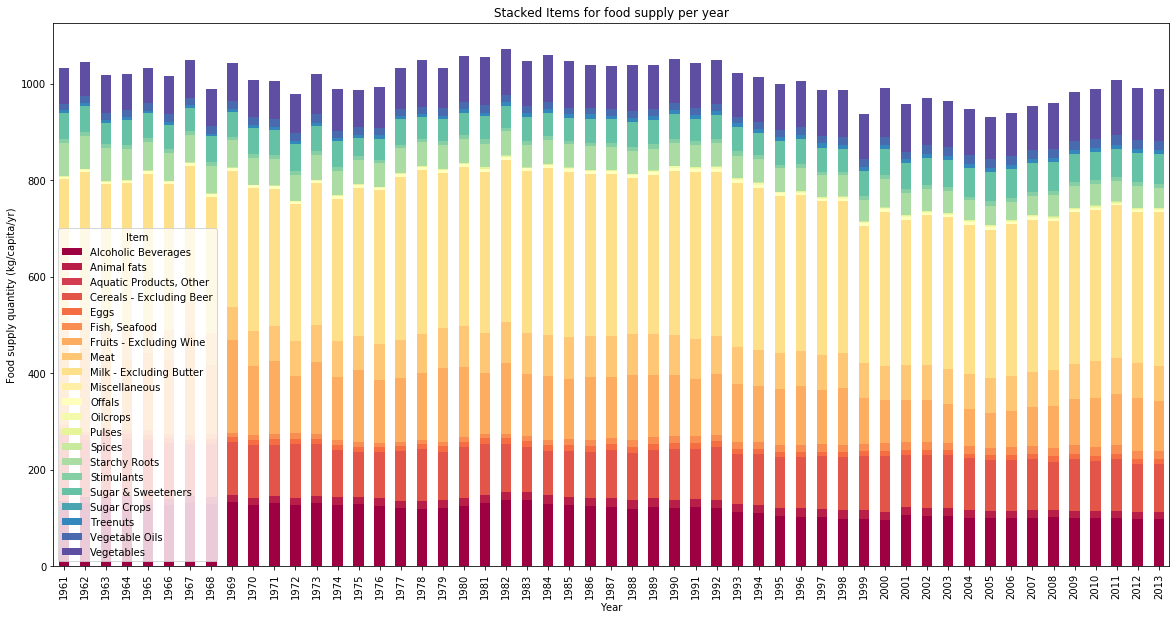

In [116]:
ax = food_supply.unstack().plot(kind='bar', stacked=True, figsize=(20,10), colormap = 'Spectral')
ax.set_title('Stacked Items for food supply per year')
ax.set_xlabel('Year')
ax.set_ylabel('Food supply quantity (kg/capita/yr)')

In [40]:
meat_supply = food_balance_df_CH_wide_groups_items[['Year', 'Item', 'Food supply quantity (kg/capita/yr)']][food_balance_df_CH_wide_groups_items['Item'] == 'Meat']

In [41]:
meat_supply = meat_supply.set_index('Year')['Food supply quantity (kg/capita/yr)']

Text(0, 0.5, 'Meet supply quantity (kg/capite/yr)')

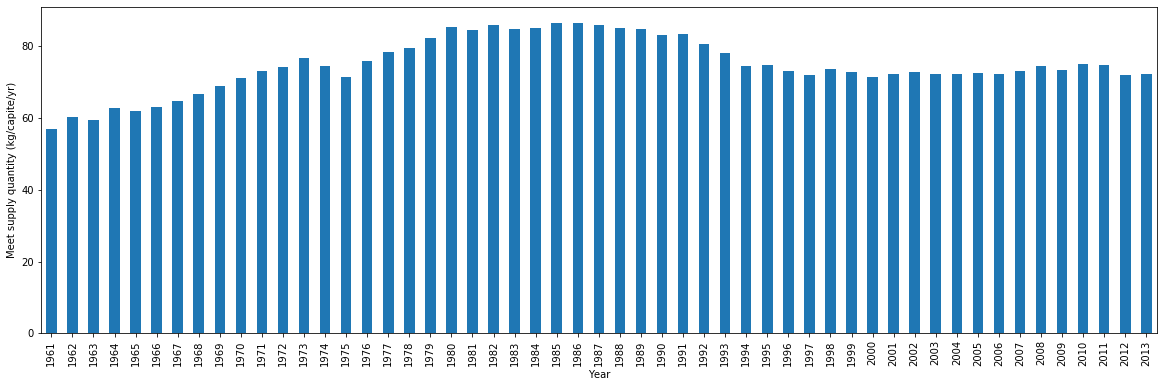

In [118]:
ax = meat_supply.plot(kind='bar', figsize=(20,6))
ax.set_xlabel('Year')
ax.set_ylabel('Meet supply quantity (kg/capite/yr)')


In [43]:
trade = food_balance_df_CH_wide_groups_items[['Year', 'Item', 'Import Quantity', 'Export Quantity', 'Feed', 'Seed', 'Production', 'Losses']]


In [44]:
import_ = trade.set_index(['Year', 'Item'])['Import Quantity']
export = trade.set_index(['Year', 'Item'])['Export Quantity']
feed = trade.set_index(['Year', 'Item'])['Feed']
seed = trade.set_index(['Year', 'Item'])['Seed']
production = trade.set_index(['Year', 'Item'])['Production']
losses = trade.set_index(['Year', 'Item'])['Losses']

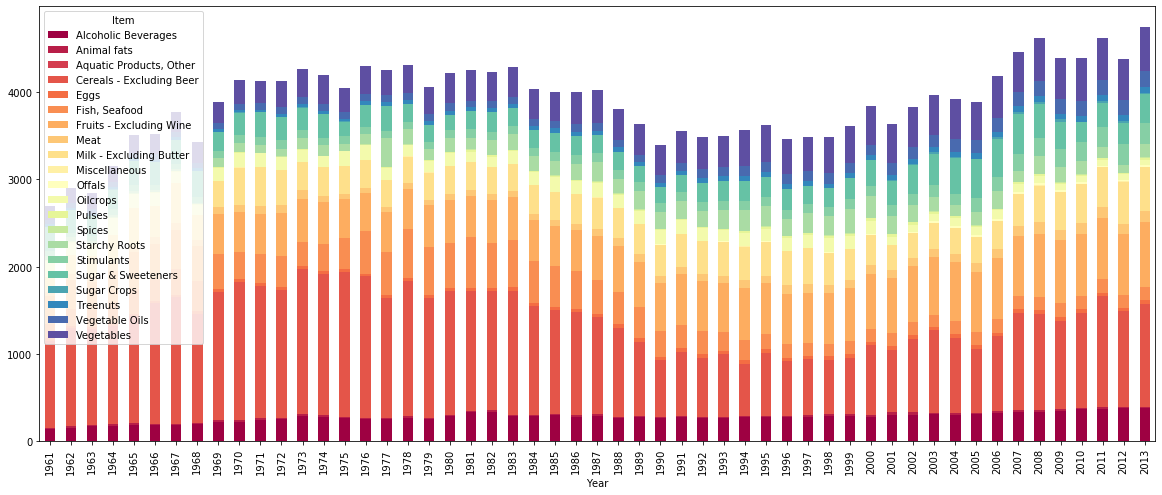

In [115]:
ax = import_.unstack().plot(kind='bar', stacked='True', figsize=(20,8), colormap='Spectral')

In [46]:
import_pct_change = import_.reset_index(level=['Year', 'Item'])
import_pct_change.columns = ['Year', 'Item', 'Pourcentage Change']

In [47]:
pct_wide = import_pct_change.pivot_table(index='Item', columns='Year', values='Pourcentage Change')
import_pct_change_wide = pd.DataFrame(import_pct_change['Item'])\
                            .merge(pct_wide, right_index=True, left_on='Item')\
                            .drop_duplicates()

In [48]:
import_pct_change_wide = import_pct_change_wide.set_index('Item').pct_change(axis='columns')

In [49]:
import_pct_change_wide = import_pct_change_wide.replace([np.NaN, np.inf], 0)


In [137]:
y = np.asarray(import_pct_change_wide.index)
x = np.arange(53)
f = lambda x: x + 1908
x = f(x)

In [138]:
x

array([1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918,
       1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929,
       1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
       1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960])

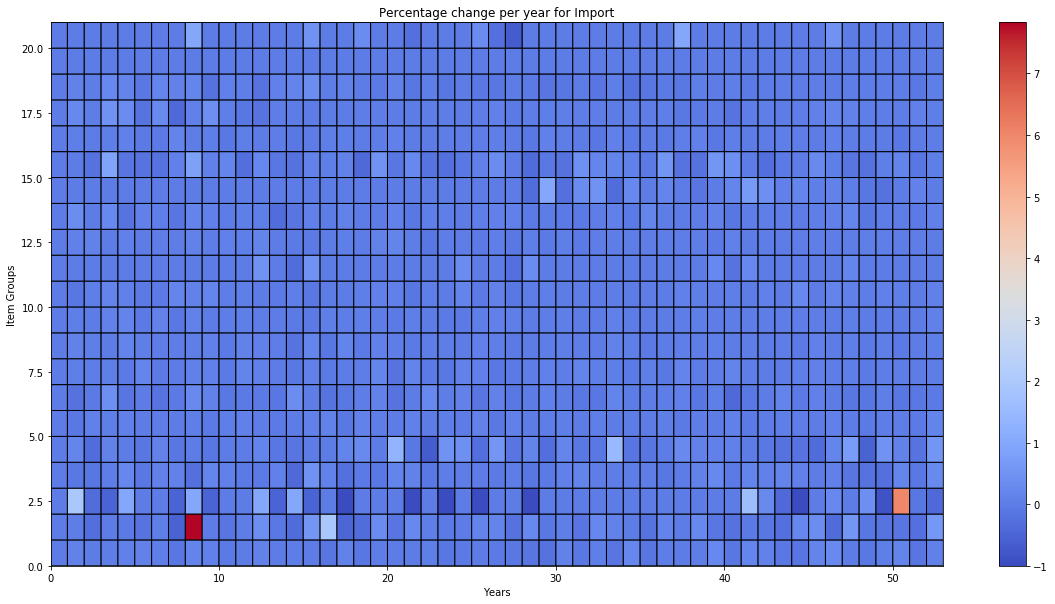

In [142]:
plt.figure(figsize=(20,10))
plt.pcolor(import_pct_change_wide, edgecolors='k', linewidths=1, cmap='coolwarm')
plt.title('Percentage change per year for Import')
plt.xlabel('Years')
plt.ylabel('Item Groups')
plt.colorbar()

In [51]:
cereal_import = food_balance_df_CH_wide_groups_items[['Year', 'Item', 'Import Quantity']]\
                        [food_balance_df_CH_wide_groups_items['Item'] == 'Cereals - Excluding Beer']

In [52]:
cereal_import = cereal_import.set_index('Year')['Import Quantity']

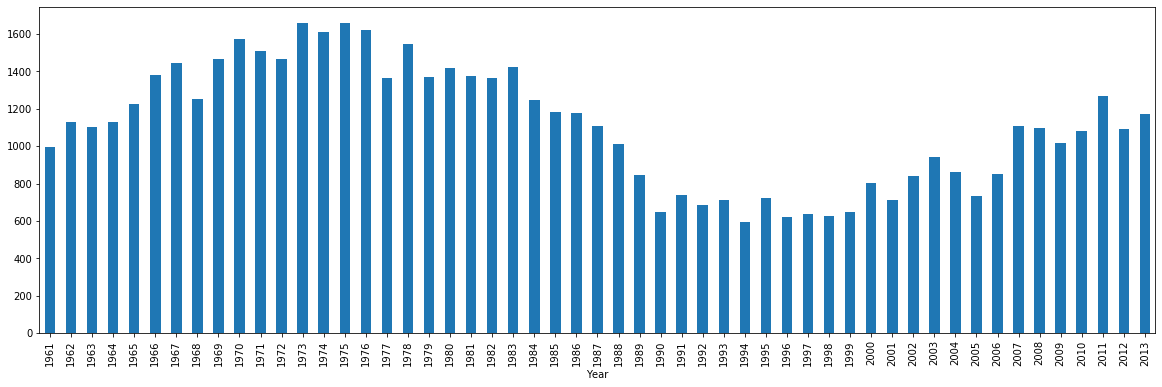

In [114]:
ax = cereal_import.plot(kind='bar', figsize=(20,6))

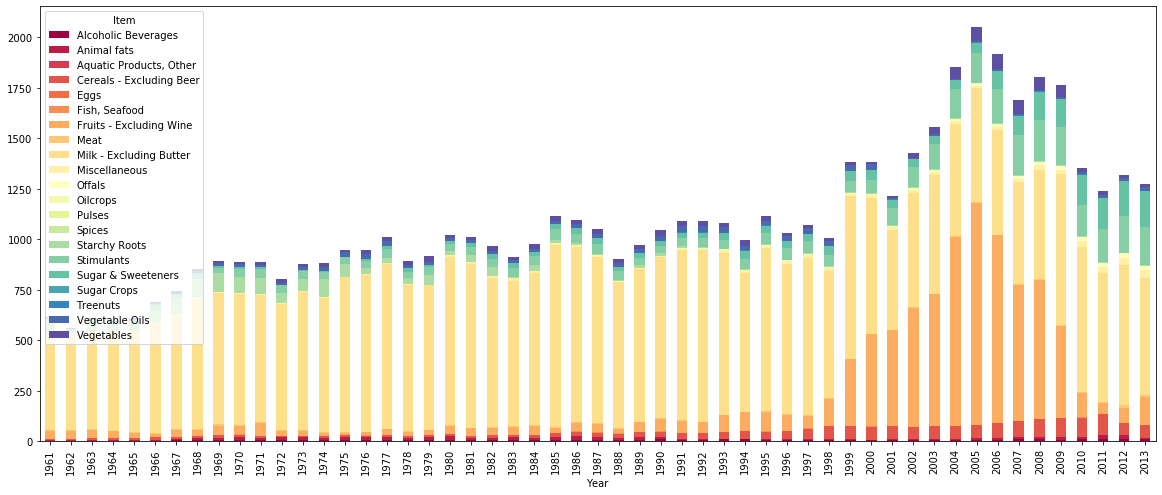

In [54]:
export.unstack().plot(kind='bar', stacked='True', figsize=(20,8), colormap='Spectral')

In [147]:
export_pct_change = get_pct_matrix(export)

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Item,,,,,,,,,,,,,,,,,,,,,
Cereals - Excluding Beer,0.0,0.200000,0.166667,0.142857,0.125000,0.222222,0.000000,0.090909,0.083333,0.076923,...,0.031250,0.000000,0.090909,0.111111,0.112500,0.033708,0.032609,0.084211,-0.417476,0.016667
Starchy Roots,0.0,-0.754386,2.142857,-0.181818,-0.111111,0.843750,0.355932,0.137500,0.021978,-0.139785,...,0.000000,-0.500000,1.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,1.000000,1.500000
Sugar Crops,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sugar & Sweeteners,0.0,0.250000,-0.200000,-0.250000,0.333333,0.250000,0.600000,0.500000,-0.083333,0.000000,...,0.047619,0.113636,0.795918,0.113636,0.428571,-0.007143,0.064748,0.060811,0.095541,0.046512
Pulses,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Treenuts,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.500000,1.000000,0.000000
Oilcrops,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,0.000000,-0.400000,-0.333333,0.000000,0.000000,0.000000,-0.500000,1.000000,-0.500000
Vegetable Oils,0.0,0.000000,0.000000,0.166667,0.142857,0.000000,0.125000,0.222222,0.181818,0.076923,...,-0.250000,0.166667,-0.142857,0.166667,0.000000,0.142857,0.625000,0.153846,-0.066667,0.357143
Vegetables,0.0,0.000000,0.000000,-0.333333,0.500000,0.333333,0.500000,0.500000,-0.111111,0.250000,...,0.727273,0.210526,0.130435,-0.141026,-0.029851,-0.107692,-0.689655,-0.111111,0.000000,-0.062500


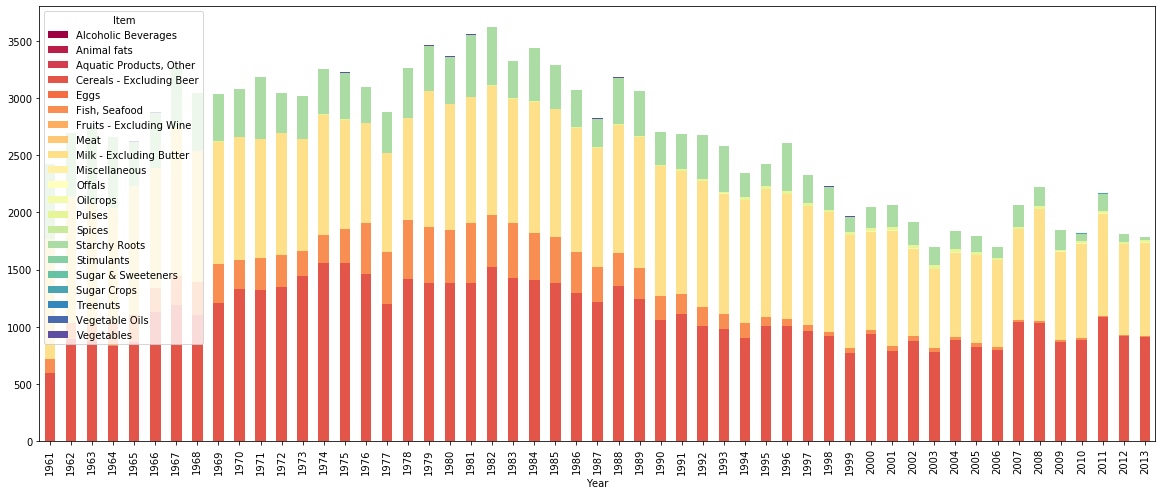

In [55]:
feed.unstack().plot(kind='bar', stacked='True', figsize=(20,8), colormap='Spectral')

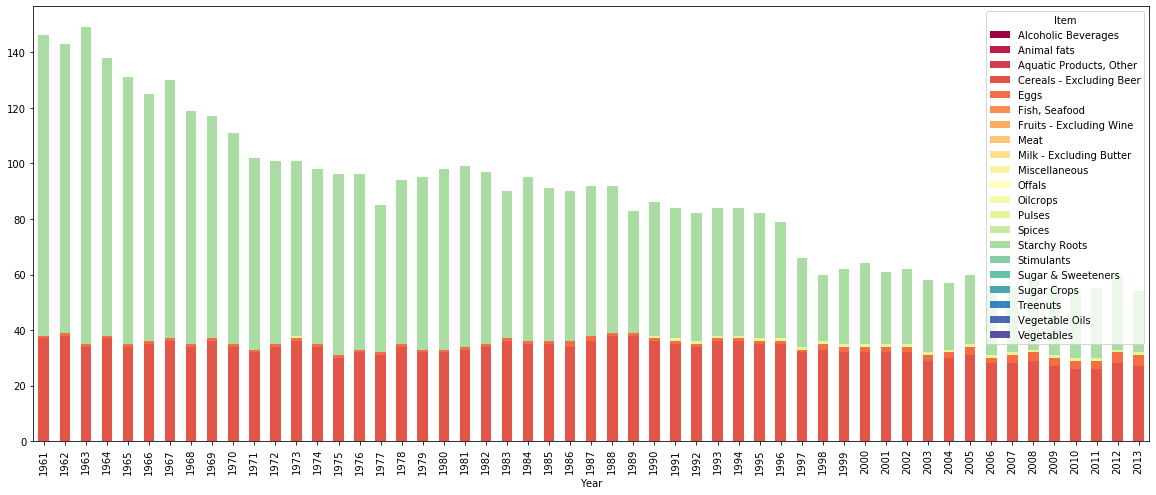

In [56]:
seed.unstack().plot(kind='bar', stacked='True', figsize=(20,8), colormap='Spectral')

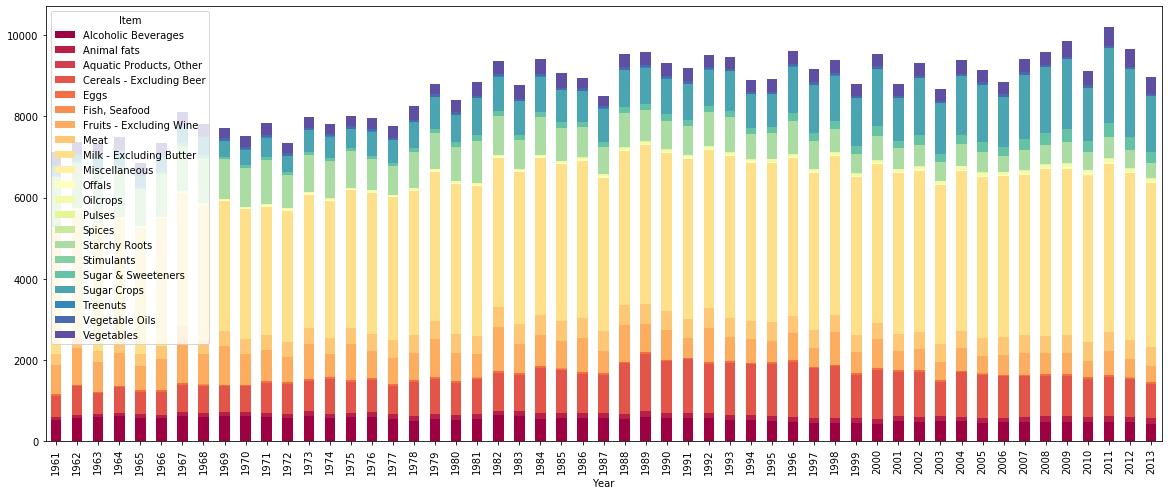

In [57]:
production.unstack().plot(kind='bar', stacked='True', figsize=(20,8), colormap='Spectral')

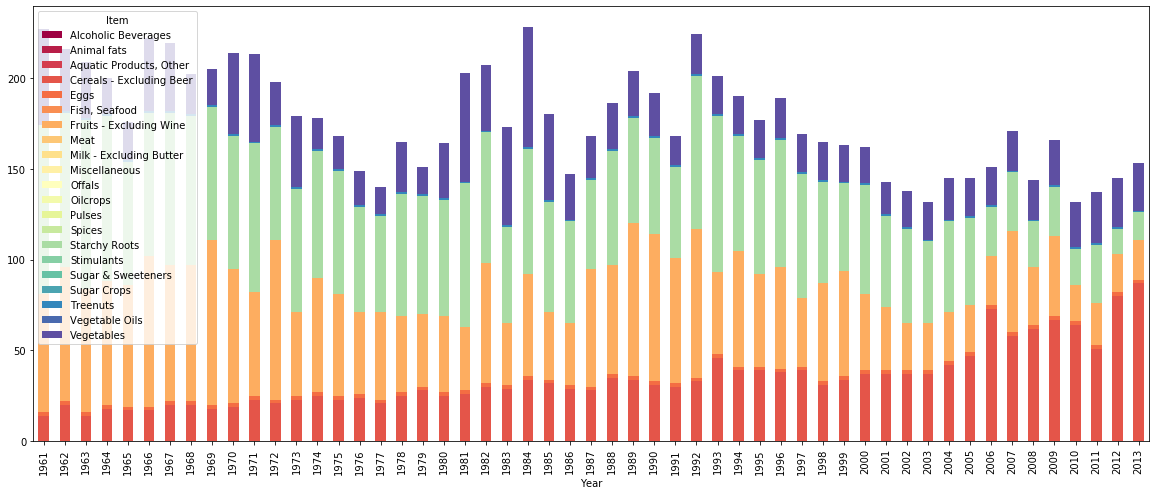

In [58]:
losses.unstack().plot(kind='bar', stacked='True', figsize=(20,8), colormap='Spectral')

---

### 1.5 Producer prices
#### 1.5.1 Data Description

The FAO Database offers a variety of datasets containing information about the consumer/producer prices of every country for all years between 1970 and 2018.
##### Producer prices -annual
<details>
  <summary>Description</summary> 
  This sub-domain contains data on Agriculture Producer Prices. These are prices received by farmers for primary crops, live animals and livestock primary products as collected at the point of initial sale (prices paid at the farm-gate). Annual data are provided from 1991 for over 160 countries and about 200 commodities.
</details>

<details>
  <summary>Path</summary>
  
  Data/FAOSTAT/Prices_E_All_Data_(Normalized).zip
</details>

##### Exchange rates -annual
<details>
  <summary>Description</summary>  
  Annual exchange rates, national currency units per U.S. dollar.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Exchange_rate_E_All_Data_(Normalized).zip
</details>

##### Producer prices -monthly
<details>
  <summary>Description</summary>  
  This sub-domain contains data on Agriculture Producer Prices (APP). These are prices received by farmers for primary crops, live animals and livestock primary products as collected at the point of initial sale (prices paid at the farm-gate). Monthly data are provided from January 2010 to December of the previous year for over 60 countries and about 200 commodities.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Prices_Monthly_E_All_Data_(Normalized).zip
</details>

##### Producer prices indices -annual
<details>
  <summary>Description</summary>  
  Indices of agricultural producer prices that measure the average annual change over time in the selling prices received by farmers (prices at the farm-gate or at the first point of sale). Annual data are provided for over 80 countries. The three categories of producer price indices available in FAOSTAT comprise: Single-item price indices, Commodity group indices and the Agriculture producer price index.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Price_Indices_E_All_Data_(Normalized).zip
</details>

##### Producer prices -archive
<details>
  <summary>Description</summary>  
  This sub-domain contains data on Agriculture Producer Prices from 1966 to 1990. These are prices received by farmers for primary crops, live animals weight and livestock primary products as collected at the point of initial sale (prices paid at the farm-gate). Data are provided for over 97 countries and for some 200 commodities.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/PricesArchive_E_All_Data_(Normalized).zip
</details>

##### Consumer prices indices 
<details>
  <summary>Description</summary>  
  The FAOSTAT monthly CPI Food CPI database was based on the ILO CPI data until December 2014. In 2014, IMF-ILO-FAO agreed to transfer global CPI data compilation from ILO to IMF. Upon agreement, CPIs for all items and its sub components originates from the International Monetary Fund (IMF), and the UN Statistics Division(UNSD) for countries not covered by the IMF. However, due to a limited time coverage from IMF and UNSD for a number of countries, the Organisation for Economic Co-operation and Development (OECD), the Latin America and the Caribbean statistics (CEPALSTAT), Central Bank of Western African States (BCEAO), Eastern Caribbean Central Bank (ECCB) and national statistical office website data are used for missing historical data from IMF and UNSD food CPI. The FAO CPI dataset for all items(or general CPI) and the Food CPI, consists of a complete and consistent set of time series from January 2000 onwards. These indices measure the price change between the current and reference periods of the average basket of goods and services purchased by households. The CPI,all items is typically used to measure and monitor inflation, set monetary policy targets, index social benefits such as pensions and unemployment benefits, and to escalate thresholds and credits in the income tax systems and wages in public and private wage contracts.
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/ConsumerPriceIndices_E_All_Data_(Normalized).zip
</details>

##### Deflators 
<details>
  <summary>Description</summary>  
  The FAOSTAT Deflators database provides the following selection of implicit price deflator series by country: Gross Domestic Product (GDP) deflator, Gross Fixed Capital Formation (GFCF) deflator, Agriculture, Forestry, Fishery Value-Added (VA_AFF) deflator, andManufacturing Valued-Added (VA_MAN) deflator. A deflator is a figure expressing the change in prices over a period of time for a product or a basket of products by comparing a reference period to a base period. It is obtained by dividing a current price value of a given aggregate by its real counterpart. When calculated from the major national accounting aggregates such as GDP or agriculture VA, implicit price deflators pertains to wider ranges of goods and services in the economy than that represented by any of the individual price indexes (such as CPIs, PPIs). Movements in an implicit price deflator reflect both changes in price and changes in the composition of the aggregate for which the deflator is calculated. In the FAOSTAT Deflators database, all series are derived from the United Nations Statistics Division (UNSD) National Accounts Estimates of Main Aggregates database (UNSD NAE). In particular, the implicit GDP deflator, the implicit GFCF deflator and the implicit value added deflator in Agriculture, Forestry, Fishery are obtained by dividing the series in current prices by those in constant 2010 prices (base year).
</details>

<details>
  <summary>Path</summary>  
  Data/FAOSTAT/Deflators_E_All_Data_(Normalized).zip
</details>

We are for now interested on the revenue that goes to local producers and their evolutions. We have producer prices -archive and producer prices -annual that will help us for having these values. Combining these two datasets will give us producer prices 1966 to 2018.
Since prices can be in different units we need the Exchange rates dataset to convert local prices into a standard unit.
We do not need Producer prices monthly because the exchange rates are annual.

#### 1.5.2 Data Cleaning

In [47]:
''' Load the data'''
prices_annual = pd.read_csv('Data/FAOSTAT/Prices_E_All_Data_(Normalized).zip', delimiter = ',', encoding = 'ISO-8859-1')
prices_arch = pd.read_csv('Data/FAOSTAT/PricesArchive_E_All_Data_(Normalized).zip', delimiter = ',', encoding = 'ISO-8859-1')
exchange_rates = pd.read_csv('Data/FAOSTAT/Exchange_rate_E_All_Data_(Normalized).zip', delimiter = ',', encoding = 'ISO-8859-1')

In [48]:
prices_annual.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1993,1993,LCU,46000.0,NaN
1,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1994,1994,LCU,50000.0,NaN
2,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1995,1995,LCU,62000.0,NaN
3,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1996,1996,LCU,50000.0,NaN
4,2,Afghanistan,221,"Almonds, with shell",5530,Producer Price (LCU/tonne),1997,1997,LCU,41000.0,NaN


In [49]:
prices_arch.head()

,CountryCode,Country,ItemCode,Item,ElementGroup,ElementCode,Element,Year,Unit,Value,Flag
0,4,Algeria,221,"Almonds, with shell",53,5530,Producer Price (LCU/tonne),1966,LCU,1150.0,F
1,4,Algeria,221,"Almonds, with shell",53,5530,Producer Price (LCU/tonne),1967,LCU,1140.0,F
2,4,Algeria,221,"Almonds, with shell",53,5530,Producer Price (LCU/tonne),1968,LCU,1210.0,F
3,4,Algeria,221,"Almonds, with shell",53,5530,Producer Price (LCU/tonne),1969,LCU,1200.0,F
4,4,Algeria,221,"Almonds, with shell",53,5530,Producer Price (LCU/tonne),1970,LCU,1200.0,F


In [50]:
exchange_rates.head()

,Area Code,Area,Item Code,Item,ISO Currency Code,Currency,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1970,1970,NaN,0.045,X,Data from UNSD AMA
1,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1971,1971,NaN,0.045,X,Data from UNSD AMA
2,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1972,1972,NaN,0.045,X,Data from UNSD AMA
3,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1973,1973,NaN,0.045,X,Data from UNSD AMA
4,2,Afghanistan,5540,Standard local currency units per USD,AFN,Afghani,1974,1974,NaN,0.045,X,Data from UNSD AMA


#### Exchange rates -annual

In [51]:
exchange_rates.columns = exchange_rates.columns.str.replace(' ', '_')

Want to check if the exchange rates are always from local currency to dollars.

In [52]:
exchange_rates.Item.unique()

array(['Standard local currency units per USD'], dtype=object)

Check if Year_Code and Year are always the same 

In [53]:
(exchange_rates.Year_Code - exchange_rates.Year).unique()

array([0])

They seem to be the same -> we can then delete one of the two

In [54]:
exchange_rates.drop(['Year_Code'], axis = 1, inplace = True)

In [55]:
exchange_rates.rename({'Value': 'Rate'}, axis = 1, inplace = True)

In [56]:
"""Select only necessary columns"""
exchange_rates = exchange_rates[['Area_Code', 'Area', 'Year', 'Rate']]
exchange_rates.drop_duplicates()
exchange_rates.head()

,Area_Code,Area,Year,Rate
0,2,Afghanistan,1970,0.045
1,2,Afghanistan,1971,0.045
2,2,Afghanistan,1972,0.045
3,2,Afghanistan,1973,0.045
4,2,Afghanistan,1974,0.045


Finally we want to know if the dataset contain nan values

In [57]:
exchange_rates.isnull().sum()

Area_Code    0
Area         0
Year         0
Rate         0
dtype: int64

Thus `exchange_rates` does not contain any nan values

##### Switzerland study

In [58]:
exchange_rates_swiss = exchange_rates.loc[exchange_rates.Area == 'Switzerland']

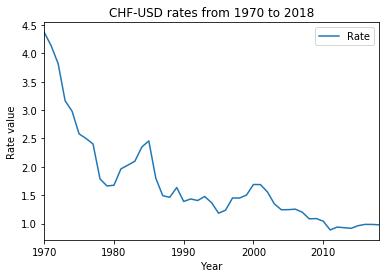

In [59]:
exchange_rates_swiss[['Rate', 'Year']].plot(kind = 'line', x = 'Year', y = 'Rate')
plt.title('CHF-USD rates from 1970 to 2018')
plt.ylabel('Rate value')
plt.show()

When looking at the rates evolution from 1970 to 2018, everything seems to be correct without outliers. High rates are present in the 70's. From 2010 the USD and the CHF are almost equal which is also expected.

#### Producer prices

##### Producer prices -annual

In [60]:
prices_annual.columns = prices_annual.columns.str.replace(' ', '_')

In [61]:
''' Checking if the dataframe contains nan values'''
prices_annual.isnull().sum()

Area_Code            0
Area                 0
Item_Code            0
Item                 0
Element_Code         0
Element              0
Year_Code            0
Year                 0
Unit                 0
Value                0
Flag            419455
dtype: int64

Again for this dataset we check if Year_Code and Year are the same

In [62]:
(prices_annual.Year_Code - prices_annual.Year).unique()

array([0])

There are the same so to be consistent with the dataframe `exchange_rates` we keep the Year column

In [63]:
prices_annual.drop(['Year_Code'], axis = 1, inplace = True)

We finally want to know in which units are the prices

##### Switzerland study

In [64]:
''' Swizerland case'''
prices_annual_swiss = prices_annual.copy()
prices_annual_swiss = prices_annual.loc[prices_annual.Area == 'Switzerland']

First let's check the different units contain in the switzerland dataset

In [65]:
prices_annual_swiss['Unit'].unique()

array(['LCU', 'SLC', 'USD'], dtype=object)

In [66]:
prices_annual_swiss['Element'].unique()

array(['Producer Price (LCU/tonne)', 'Producer Price (SLC/tonne)',
       'Producer Price (USD/tonne)'], dtype=object)

In [67]:
prices_annual_swiss['Element_Code'].unique()

array([5530, 5531, 5532])

Since three different units appear in the switzerland producer prices -annual dataset, we need to have a standard unit to able to compare values. This is achived by joining `prices_annual_swiss` dataframe with the `exchange_rates` dataframe. The standard unit will be dollars(USD) since the `exchange_rates` dataframe is based on dollars.

In [68]:
''' Prices in USD unit'''
prices_annual_swiss_usd = prices_annual_swiss.loc[prices_annual_swiss.Unit == 'USD']
prices_annual_swiss_usd.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value,Flag
389937,211,Switzerland,515,Apples,5532,Producer Price (USD/tonne),1991,USD,684.8,NaN
389938,211,Switzerland,515,Apples,5532,Producer Price (USD/tonne),1992,USD,342.1,NaN
389939,211,Switzerland,515,Apples,5532,Producer Price (USD/tonne),1993,USD,457.5,NaN
389940,211,Switzerland,515,Apples,5532,Producer Price (USD/tonne),1994,USD,452.6,NaN
389941,211,Switzerland,515,Apples,5532,Producer Price (USD/tonne),1995,USD,643.6,NaN


In [69]:
''' Prices in LCU (local currency unit) unit'''
prices_annual_swiss_lcu = prices_annual_swiss.loc[prices_annual_swiss.Unit == 'LCU']
prices_annual_swiss_lcu.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value,Flag
389881,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1991,LCU,982.0,NaN
389882,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1992,LCU,481.0,NaN
389883,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1993,LCU,676.0,NaN
389884,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1994,LCU,619.0,NaN
389885,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1995,LCU,761.0,NaN


In [70]:
''' Prices in SLC (standard local currency) unit'''
prices_annual_swiss_slc = prices_annual_swiss.loc[prices_annual_swiss.Unit == 'SLC']
prices_annual_swiss_slc.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value,Flag
389909,211,Switzerland,515,Apples,5531,Producer Price (SLC/tonne),1991,SLC,982.0,NaN
389910,211,Switzerland,515,Apples,5531,Producer Price (SLC/tonne),1992,SLC,481.0,NaN
389911,211,Switzerland,515,Apples,5531,Producer Price (SLC/tonne),1993,SLC,676.0,NaN
389912,211,Switzerland,515,Apples,5531,Producer Price (SLC/tonne),1994,SLC,619.0,NaN
389913,211,Switzerland,515,Apples,5531,Producer Price (SLC/tonne),1995,SLC,761.0,NaN


The length of the prices with USD, SLC and LCU are the same. We can think that prices are reproduced three times in the switzerland dataset.
To be sure let transform SLC and LCU unit into USD unit.

In [71]:
''' 
Check if datasets containg LCU and SLC units are the same.
Unit, Element, Element_Code are columns referencing the unit used, we can then work without these columns 
for checking equality.
'''
prices_annual_swiss_slc.loc[prices_annual_swiss_slc.Unit == 'LCU'][prices_annual_swiss_slc.columns.difference(['Unit', 'Element', 'Element_Code'])].equals(prices_annual_swiss_lcu.loc[prices_annual_swiss_lcu.Unit == 'SLC'][prices_annual_swiss_lcu.columns.difference(['Unit', 'Element', 'Element_Code'])])

True

The dataset containg with SLC and LCU unit are equals. Thus we only have to transform one of the two dataset into USD unit.

In [72]:
prices_annual_swiss_lcu_usd = prices_annual_swiss.loc[prices_annual_swiss.Unit == 'LCU'].merge(exchange_rates, left_on = ['Area_Code', 'Area', 'Year'], right_on = ['Area_Code', 'Area', 'Year'], suffixes=('', '_to_delete'))
prices_annual_swiss_lcu_usd['Value'] = prices_annual_swiss_lcu_usd['Value'] / prices_annual_swiss_lcu_usd['Rate']
prices_annual_swiss_lcu_usd.drop(columns = ['Rate'], inplace = True)
prices_annual_swiss_lcu_usd['Unit'] = 'USD'
prices_annual_swiss_lcu_usd['Element'] = 'Producer Price (USD/tonne)'
prices_annual_swiss_lcu_usd['Element_Code'] = 5532
prices_annual_swiss_lcu_usd.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value,Flag
0,211,Switzerland,515,Apples,5532,Producer Price (USD/tonne),1991,USD,684.797768,NaN
1,211,Switzerland,526,Apricots,5532,Producer Price (USD/tonne),1991,USD,1377.266388,NaN
2,211,Switzerland,44,Barley,5532,Producer Price (USD/tonne),1991,USD,481.171548,NaN
3,211,Switzerland,414,"Beans, green",5532,Producer Price (USD/tonne),1991,USD,942.817294,NaN
4,211,Switzerland,358,Cabbages and other brassicas,5532,Producer Price (USD/tonne),1991,USD,837.517434,NaN


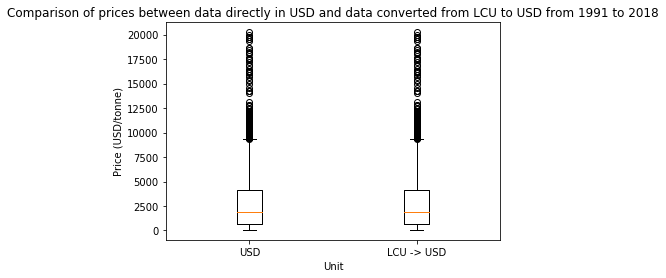

In [73]:
names = ['USD', 'LCU -> USD']
plt.boxplot([prices_annual_swiss_usd['Value'], prices_annual_swiss_lcu_usd['Value']])
plt.xticks([1, 2], names)
plt.title('Comparison of prices between data directly in USD and data converted from LCU to USD from 1991 to 2018')
plt.xlabel('Unit')
plt.ylabel('Price (USD/tonne)')
plt.show()

Distribution seems to be the same, let's check if these two datasets are equal.

In [74]:
prices_annual_swiss_usd.loc[prices_annual_swiss_usd.Unit == 'LCU'][prices_annual_swiss_usd.columns.difference(['Unit', 'Element', 'Element_Code'])].equals(prices_annual_swiss_lcu_usd.loc[prices_annual_swiss_lcu_usd.Unit == 'SLC'][prices_annual_swiss_lcu_usd.columns.difference(['Unit', 'Element', 'Element_Code'])])

True

Thus, we can conclude that for the case of swizerland, data is well organized without any outliers.

##### Producer prices -archive

In [75]:
prices_arch = prices_arch.rename(columns = {'CountryCode': 'Area_Code', 
                                            'Country': 'Area',
                                            'ItemCode': 'Item_Code',
                                            'ElementGroup': 'Element_Group',
                                            'ElementCode': 'Element_Code'})

In [76]:
prices_arch['Unit'].unique()

array(['LCU'], dtype=object)

In [77]:
prices_arch['Element'].unique()

array(['Producer Price (LCU/tonne)'], dtype=object)

In [78]:
prices_arch['Element_Code'].unique()

array([5530])

In [79]:
prices_arch['Element_Group'].unique()

array([53])

Element_Group column is only present in prices_arch and has a single value. We can then delete this column.

In [80]:
prices_arch.drop(columns = ['Element_Group'], inplace = True)

`prices_arch` dataframe contains only prices in local currency unit (LCU). Thus, we need to convert everything into our standard format: USD unit.

In [81]:
prices_arch_swiss = prices_arch.loc[prices_arch.Area == 'Switzerland']
prices_arch_swiss.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value,Flag
119920,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1966,LCU,260.0,F
119921,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1967,LCU,230.0,F
119922,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1968,LCU,230.0,F
119923,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1969,LCU,230.0,F
119924,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1970,LCU,230.0,F


In [82]:
prices_arch_swiss_lcu_usd = prices_arch_swiss.merge(exchange_rates, left_on = ['Area_Code', 'Area', 'Year'], right_on = ['Area_Code', 'Area', 'Year'], suffixes=('', '_to_delete'))
prices_arch_swiss_lcu_usd.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value,Flag,Rate
0,211,Switzerland,515,Apples,5530,Producer Price (LCU/tonne),1970,LCU,230.0,F,4.373
1,211,Switzerland,526,Apricots,5530,Producer Price (LCU/tonne),1970,LCU,830.0,F,4.373
2,211,Switzerland,44,Barley,5530,Producer Price (LCU/tonne),1970,LCU,436.0,NaN,4.373
3,211,Switzerland,414,"Beans, green",5530,Producer Price (LCU/tonne),1970,LCU,1351.0,F,4.373
4,211,Switzerland,358,Cabbages and other brassicas,5530,Producer Price (LCU/tonne),1970,LCU,539.0,F,4.373


In [83]:
prices_arch_swiss_lcu_usd['Value'] = prices_arch_swiss_lcu_usd['Value'] / prices_arch_swiss_lcu_usd['Rate']
prices_arch_swiss_lcu_usd.drop(columns = ['Rate', 'Flag'], inplace = True)
prices_arch_swiss_lcu_usd['Unit'] = 'USD'
prices_arch_swiss_lcu_usd['Element'] = 'Producer Price (USD/tonne)'
prices_arch_swiss_lcu_usd['Element_Code'] = 5532
prices_arch_swiss_lcu_usd.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value
0,211,Switzerland,515,Apples,5532,Producer Price (USD/tonne),1970,USD,52.595472
1,211,Switzerland,526,Apricots,5532,Producer Price (USD/tonne),1970,USD,189.801052
2,211,Switzerland,44,Barley,5532,Producer Price (USD/tonne),1970,USD,99.702721
3,211,Switzerland,414,"Beans, green",5532,Producer Price (USD/tonne),1970,USD,308.941230
4,211,Switzerland,358,Cabbages and other brassicas,5532,Producer Price (USD/tonne),1970,USD,123.256346


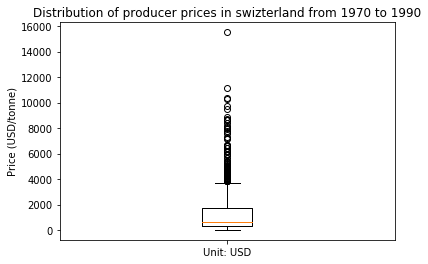

In [84]:
plt.boxplot(prices_arch_swiss_lcu_usd['Value'])
plt.xticks([1], ['Unit: USD'])
plt.title('Distribution of producer prices in swizterland from 1970 to 1990')
plt.ylabel('Price (USD/tonne)')
plt.show()

Producer prices seems to be smaller in `prices_arch_swiss_lcu_usd` dataframe compare to `prices_annual_swiss_lcu_usd` dataframe which is expected since `prices_arch_swiss_lcu_usd` dataset correspond to prices from 1970 to 1996 and  `prices_arch_swiss_lcu_usd` dataset correspond to prices from 1997 to 2018 and we all know that prices increased over the years.

We then have to concatenate `prices_arch_swiss_lcu_usd` and `prices_annual_swiss_lcu_usd` dataframe to have values from 1970 to 2018 in USD in only one dataframe.
We call this new dataframe `producer_prices_swiss`

In [85]:
producer_prices_swiss = pd.concat([prices_arch_swiss_lcu_usd, prices_annual_swiss_lcu_usd], ignore_index=True, sort = False)
producer_prices_swiss.head()

,Area_Code,Area,Item_Code,Item,Element_Code,Element,Year,Unit,Value,Flag
0,211,Switzerland,515,Apples,5532,Producer Price (USD/tonne),1970,USD,52.595472,NaN
1,211,Switzerland,526,Apricots,5532,Producer Price (USD/tonne),1970,USD,189.801052,NaN
2,211,Switzerland,44,Barley,5532,Producer Price (USD/tonne),1970,USD,99.702721,NaN
3,211,Switzerland,414,"Beans, green",5532,Producer Price (USD/tonne),1970,USD,308.941230,NaN
4,211,Switzerland,358,Cabbages and other brassicas,5532,Producer Price (USD/tonne),1970,USD,123.256346,NaN


# Readme update 

After a deep study of the datasets and a long reflexion on the topic we decided to add the following updates to the readme file:


- Removal of the **Open food facts database** from our ressource list because of the non relevance of the informations it contains

- Change the way we study the food carbon print and link it to the provenance of the products.

- Removal of the average meal concept and replace it by the amount of consumed food per capita.

- Dropping of the e-shop webscraping idea. 


# What's next ? 

The preliminary analysis of the data allowed us to discover what FAOSTAT datasets really contain and inform ourselves about the feasibility of our researches. The next step would be to move forward with the data analysis and visualization. 

First we are going to categorize the food products into a small number of relevant categories and study the top 5 most exporters to switzerland of each of them using the 'Trade' datasets, we will mainly use and adapt the existing categories in 'Food balance sheets'

Second, we will study the evolution of the imports and exports of those categories as well as the evolution of their provenance

Finally, the focus will be on the analysis of the food carbon emissions in Kg/per capita in switzerland and the impact of the food provenance of those values.


### Still pending 

One important step that is still pending is getting the access to the Eaternity [API](https://eaternity.docs.apiary.io/#introduction/indicators-results/environmental-footprints) that provide us accurate data about the food carbon footprint of each product. 


The negotiations for a discounted price or a free access to their [database](https://eaternity.org/foodprint/database) are still ongoing. We hope that we can convince the eaternity team to support us in this project.

With the help of this webservice we can study the evolution of the carbon foodprint in switzerland and see if it's possible to reduce those emissions by changing our food import sources.

